# Topical Expert Model

In [254]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/brandon
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)

CPU times: user 1min 3s, sys: 23.3 s, total: 1min 26s
Wall time: 1min 38s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 5.25 s, sys: 453 ms, total: 5.7 s
Wall time: 6.06 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 53.3 s, sys: 17.5 s, total: 1min 10s
Wall time: 1min 21s


Sort by category

In [24]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [83]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 15)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food']

In [9]:
%%time
businessReviews = pd.merge(review, restaurants,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'text', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'text', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 38 s, sys: 28.2 s, total: 1min 6s
Wall time: 1min 37s


In [82]:
display(len(businessReviews))
display(len(bus_rev_users))
display(list(businessReviews))
display(list(bus_rev_users))

2927731

2927731

['business_id',
 'cool',
 'funny',
 'review_id',
 'stars_x',
 'text',
 'useful',
 'user_id',
 'categories',
 'review_count',
 'stars_y']

['business_id',
 'cool_x',
 'funny_x',
 'review_id',
 'stars_x',
 'text',
 'useful_x',
 'user_id',
 'categories',
 'stars_y',
 'average_stars',
 'cool_y',
 'elite',
 'fans',
 'friends',
 'name',
 'review_count_y',
 'yelping_since']

## Feature Extraction From Yelp Data

In [129]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [134]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

In [184]:
%%time
# Lets do places with categories Chinese Restaurant
categories = ['Restaurants','Chinese']
feature_set_1 = feature1(businessReviews, bus_rev_users, categories)

CPU times: user 12.4 s, sys: 7.7 s, total: 20.1 s
Wall time: 29.4 s


In [185]:
display(len(feature_set_1))
display(feature_set_1.head(5))

109685

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,kzyLOqiJvyw_FWFTw2rjiQ,2,1,1.0,0.000000,0,0,0,16,[],0
1,WZXp9-V2dqRRJqhGgRqueA,327,4,2.5,1.000000,4,6,4,61,"[2016, 2015]",1
2,XylT12exfdLiI_3uDLVIpw,344,1,5.0,0.000000,1,2,1,84,[],0
3,Ji9PeffxjwqPLO7pEfSpKQ,93,6,2.5,1.048809,6,9,7,107,"[2010, 2009]",1
4,TLIWzAJPrET0zX4_vgvLhg,53,1,3.0,0.000000,0,0,0,38,[],0


## Classifier Setups (Sklearn Library)*

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [248]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives the classifications'''
def run_model(clf, features):
    train, test = train_test_split(X)
    train_classifier = train['is_expert'].values
    test_classifier = test['is_expert'].values
    train = train.drop('is_expert',axis=1)
    test = test.drop('is_expert', axis=1)
    clf.fit(train, train_classifier)
    rf_pred = clf.predict(test)
    model_perf= {'Model_Score' : clf.score(test, test_classifier),
                'Predictions' : rf_pred,
                'Actual' : test_classifier,
                'Prediction_Probabilities' : clf.predict_proba(test),
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Experts_Actual' : sum(test_classifier),
                'Num_Experts_Training' : sum(train_classifier)} 
    return model_perf

'''Runs the model n times, and prints out a dictionary with the statistics'''
def bootstrap_model(clf, features, n):
    models = []
    for i in range(1,n):
        models.append(run_model(clf, features))
    return models

'''Gets statistics from the bootstrap list of dictionaries'''
def boot_statistics(models):
    stats = []
    mean_model_score = np.mean([i['Model_Score'] for i in models])
    expert_pred_percentage = [i['Num_Experts_Predicted']/i['Num_Experts_Actual'] for i in models]
    mn = np.array((1.0 - np.array(mean_model_score))) * np.array(models[0]['Total_Tested'])
    stats = {'Mean_Wrong_Predictions' : round(mn),
             'Mean_Model_Score' : mean_model_score, 
             'Expert_Prediction_Percentage' : expert_pred_percentage}
    return stats

def graph_from_statistics(stats):
    return 0

 #### Drop unnessary columns from the features table (call it X).

In [197]:
X = feature_set_1.drop('user_id',axis=1).drop('elite',axis=1)

## Run a random forest classifier

In [206]:
clf_RF = RandomForestClassifier(max_depth=3)
display(run_model(clf_RF,X))
RF_bootstrap = bootstrap_model(clf_RF, X, 10)

{'Actual': array([0, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.91944424184960982,
 'Num_Experts_Actual': 3541,
 'Num_Experts_Predicted': 2210,
 'Num_Experts_Training': 10829,
 'Prediction_Probabilities': array([[ 0.93322993,  0.06677007],
        [ 0.95333022,  0.04666978],
        [ 0.8745697 ,  0.1254303 ],
        ..., 
        [ 0.96599205,  0.03400795],
        [ 0.95333022,  0.04666978],
        [ 0.91336883,  0.08663117]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

## Run a gaussian naive bayes classifier

In [199]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
display(run_model(clf_NB,X))
NB_bootstrap = bootstrap_model(clf_NB, X, 10)

{'Actual': array([0, 1, 0, ..., 0, 0, 1]),
 'Model_Score': 0.90514915031726351,
 'Num_Experts_Actual': 3674,
 'Num_Experts_Predicted': 2017,
 'Num_Experts_Training': 10696,
 'Prediction_Probabilities': array([[  9.99999935e-01,   6.53938856e-08],
        [  9.85439891e-01,   1.45601087e-02],
        [  9.99999141e-01,   8.59343888e-07],
        ..., 
        [  9.99999573e-01,   4.27225466e-07],
        [  9.99999748e-01,   2.52462230e-07],
        [  4.21630157e-35,   1.00000000e+00]]),
 'Predictions': array([0, 0, 0, ..., 0, 0, 1]),
 'Total_Tested': 27422}

## Run a decision tree classifier

In [212]:
clf_DT = tree.DecisionTreeClassifier()
display(run_model(clf_DT, X))
DT_bootstrap = bootstrap_model(clf_DT, X, 10)

{'Actual': array([1, 0, 0, ..., 0, 0, 0]),
 'Model_Score': 0.90358106629713364,
 'Num_Experts_Actual': 3547,
 'Num_Experts_Predicted': 3559,
 'Num_Experts_Training': 10823,
 'Prediction_Probabilities': array([[ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]),
 'Predictions': array([1, 0, 0, ..., 0, 0, 0]),
 'Total_Tested': 27422}

In [255]:
DT_stats = boot_statistics(DT_bootstrap)
NB_stats = boot_statistics(NB_bootstrap)
RF_stats = boot_statistics(RF_bootstrap)
display(DT_stats)
display(NB_stats)
display(RF_stats)
y = [DT_stats['Mean_Model_Score'],NB_stats['Mean_Model_Score'],RF_stats['Mean_Model_Score']]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width)

fig = plt.gcf()

{'Expert_Prediction_Percentage': [1.0104549307714044,
  0.99456521739130432,
  1.0211817168338908,
  1.0278706800445931,
  1.0165242165242165,
  1.0379926282960024,
  1.0158113730929266,
  0.99207000273448187,
  1.0245467224546723],
 'Mean_Model_Score': 0.9038525433755541,
 'Mean_Wrong_Predictions': 2637.0}

{'Expert_Prediction_Percentage': [0.60297908908622166,
  0.58833426808749301,
  0.57820299500831951,
  0.5572519083969466,
  0.56441201234914395,
  0.6188616071428571,
  0.5720303285593934,
  0.5728486225504118,
  0.58679085520745133],
 'Mean_Model_Score': 0.90823669559720899,
 'Mean_Wrong_Predictions': 2516.0}

{'Expert_Prediction_Percentage': [0.31736361118803658,
  0.59917241379310349,
  0.43278688524590164,
  0.75717801476620183,
  0.44516129032258067,
  0.682032768675368,
  0.3572021011888305,
  0.55850622406639006,
  0.5118778280542986],
 'Mean_Model_Score': 0.90940769374144048,
 'Mean_Wrong_Predictions': 2484.0}

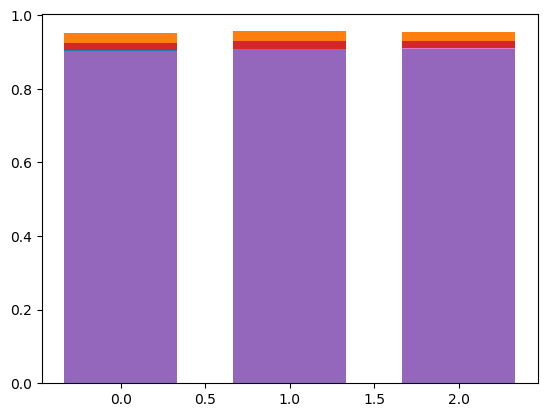

In [256]:
fig